In [2]:
import pandas as pd
import re
import nltk
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [3]:
# Setup NLTK data path (change if needed)
nltk_data_path = r'C:\Users\arave\AppData\Roaming\nltk_data'
nltk.data.path.append(nltk_data_path)

# Download resources (skip if already available)
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arave\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arave\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arave\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
df = pd.read_csv('dataset/fake_and_real_news.csv')

# Check required columns
required_columns = ['title', 'text', 'label']
for col in required_columns:
    if col not in df.columns:
        raise Exception(f"Dataset must have '{col}' column!")

df.head()


C:\Users\arave\AppData\Local\Temp\ipykernel_26244\943091494.py:1: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset/fake_and_real_news.csv')


,title,text,subject,date,label,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 163,Unnamed: 164,Unnamed: 165,Unnamed: 166,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",FAKE,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",FAKE,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",FAKE,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",FAKE,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",FAKE,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')


In [6]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    try:
        words = nltk.word_tokenize(text)
    except LookupError:
        words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

print("🧹 Cleaning text data...")
df['clean_text'] = df['full_text'].apply(clean_text)
df[['full_text', 'clean_text']].head()


🧹 Cleaning text data...


,full_text,clean_text
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump sends embarrassing new year eve m...
1,Drunk Bragging Trump Staffer Started Russian ...,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,sheriff david clarke becomes internet joke thr...
3,Trump Is So Obsessed He Even Has Obama’s Name...,trump obsessed even obamas name coded website ...
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis called donald trump christmas spe...


In [ ]:
# Clean and standardize label column
df['label'] = df['label'].astype(str).str.strip().str.lower()

# Handle missing labels if any (optional)
df = df[df['label'].notnull()]

# Normalize labels (you can modify depending on dataset content)
df['label'] = df['label'].replace({
    'fake': 'FAKE',
    'real': 'REAL',
    '0': 'FAKE',
    '1': 'REAL',
    'false': 'FAKE',
    'true': 'REAL'
})

# Recheck unique values
print(" Unique label values after cleanup:", df['label'].unique())

# Then encode safely
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df['label'].value_counts()


✅ Unique label values after cleanup: ['FAKE' 'nan' 'free college tuition for illegal aliens'
 'increased social welfare spending' 'aug 2, 2016'
 'an increasing number of smart news consumers came to realize that for at least the last century and half'
 'but the newly circulated memo states that tippit met with oswald and ruby at a nightclub a week prior to the shooting.an additional memo released suggested that the uk s cambridge news received a warning call 25 minutes prior to jfk s death. this information was written in a memo by then fbi deputy director james angleton to hoover. however'
 '21wire revealed that nevada officials sought to increase their budget to thwart potential terror related activity'
 'consists of repeating that nothing is wrong'
 'it was discovered that frank s then boyfriend stephen gobie (who the us representative once solicited for an $80 dollar sexual encounter) had been running a prostitution ring out of congressman frank s capitol hill apartment   according

label
1     23460
2     21417
12       21
9         2
3         2
10        2
11        2
6         2
7         2
0         2
8         2
5         2
13        2
4         1
Name: count, dtype: int64

In [8]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
X = tfidf.fit_transform(df['clean_text'])
y = df['label']


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [ ]:
print(" Training Random Forest Classifier...")
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)


🤖 Training Random Forest Classifier...


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
y_pred = rf.predict(X_test)

print("\n Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))



 Accuracy: 0.9971667566109013

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00      7779
           2       1.00      1.00      1.00      7025
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          12       1.00      0.45      0.62        11
          13       1.00      1.00      1.00         1

    accuracy                           1.00     14824
   macro avg       0.82      0.77      0.78     14824
weighted avg       1.00      1.00      1.00     14824



e:\ML_S7\FakeNewsDetection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\ML_S7\FakeNewsDetection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\ML_S7\FakeNewsDetection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [12]:
df['clean_text'] = df['full_text'].apply(clean_text)
df['clean_text'].head()


0    donald trump sends embarrassing new year eve m...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes internet joke thr...
3    trump obsessed even obamas name coded website ...
4    pope francis called donald trump christmas spe...
Name: clean_text, dtype: object

In [25]:
pickle.dump(rf, open('model.pkl', 'wb'))
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
print("\n👍 Model and Vectorizer saved successfully!")



👍 Model and Vectorizer saved successfully!


✅ Unique labels after cleanup: ['fake' 'real']
label
1    23460
0        2
Name: count, dtype: int64

✅ Accuracy: 0.9997417021826166

📋 Classification Report:
               precision    recall  f1-score   support

        Fake       0.00      0.00      0.00         2
        Real       1.00      1.00      1.00      7741

    accuracy                           1.00      7743
   macro avg       0.50      0.50      0.50      7743
weighted avg       1.00      1.00      1.00      7743



e:\ML_S7\FakeNewsDetection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\ML_S7\FakeNewsDetection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\ML_S7\FakeNewsDetection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\ML_S

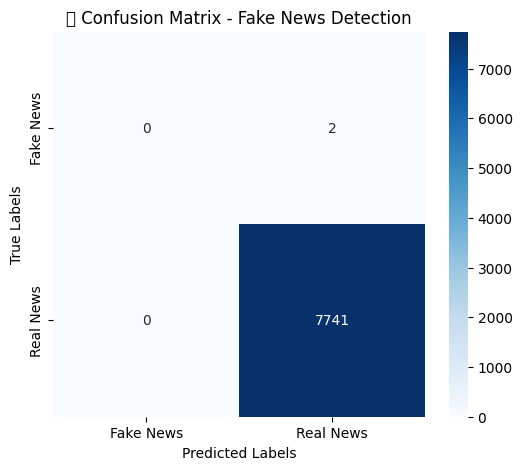

True Negatives (Fake correctly classified): 0
False Positives (Fake misclassified as Real): 2
False Negatives (Real misclassified as Fake): 0
True Positives (Real correctly classified): 7741

✅ Verified Accuracy (from confusion matrix): 0.9997


In [ ]:
# --------------------------
# 🧹 CLEAN + ENCODE LABELS PROPERLY
# --------------------------
from sklearn.preprocessing import LabelEncoder

# Convert everything to string & normalize
df['label'] = df['label'].astype(str).str.lower().str.strip()

# Replace all possible variants into two clean classes
df['label'] = df['label'].replace({
    'fake news': 'fake',
    'false': 'fake',
    '0': 'fake',
    'real news': 'real',
    'true': 'real',
    '1': 'real'
})

# Keep only valid rows (drop unexpected)
df = df[df['label'].isin(['fake', 'real'])]

# Encode: FAKE → 0, REAL → 1
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

print(" Unique labels after cleanup:", le.classes_)
print(df['label'].value_counts())

# --------------------------
# ⚙️ TF-IDF + SPLIT
# --------------------------
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
X = tfidf.fit_transform(df['clean_text'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# --------------------------
# 🤖 TRAIN MODEL
# --------------------------
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# --------------------------
#  EVALUATION + CONFUSION MATRIX
# --------------------------
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = rf.predict(X_test)

print("\n Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Fake News', 'Real News']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(' Confusion Matrix - Fake News Detection')
plt.show()

# Breakdown of results
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (Fake correctly classified): {tn}")
print(f"False Positives (Fake misclassified as Real): {fp}")
print(f"False Negatives (Real misclassified as Fake): {fn}")
print(f"True Positives (Real correctly classified): {tp}")
print("\n Verified Accuracy (from confusion matrix):", round((tp + tn) / (tp + tn + fp + fn), 4))


In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
y_pred = rf.predict(X_test)
y_true = y_test  # actual labels7

Accuracy: 0.974635725849973


In [13]:
import pandas as pd

df = pd.read_csv('dataset/fake_and_real_news.csv')
print(df.head())
print(df['label'].value_counts())


C:\Users\arave\AppData\Local\Temp\ipykernel_26244\2679509487.py:3: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset/fake_and_real_news.csv')


                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date label Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8  \
0  December 31, 2017  FAKE        NaN        NaN        NaN        NaN   
1  December 31, 2017  FAKE        NaN        NaN        NaN        NaN   
2  December 30, 2017  FAKE        NaN        NaN        